In [1]:
import numpy as np
import statsmodels.tsa.stattools as stm
import scipy.stats as sc
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.cluster import KMeans, DBSCAN
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, year, to_date
import folium

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [3]:
findspark.init()
spark = SparkSession.builder.appName("Ownership").getOrCreate()

In [4]:
ownership_data = spark.read.csv("../../data/clean_data/clean_car_ownership.csv", header=True, inferSchema=True)
sales_data = spark.read.csv("../../data/clean_data/clean_car_sales.csv", header=True, inferSchema=True)

ownership_data = ownership_data.withColumnRenamed('Annual Income', 'Annual_Income')
ownership_data = ownership_data.withColumnRenamed('Years of Employment', 'Years_of_Employment')
ownership_data = ownership_data.withColumnRenamed('Credit Score', 'Credit_Score')
ownership_data = ownership_data.withColumnRenamed('Finance Status', 'Finance_Status')
ownership_data = ownership_data.withColumnRenamed('Number of Children', 'Number_of_Children')

sales_data = sales_data.withColumnRenamed('Annual Income', 'Annual_Income')
sales_data = sales_data.withColumnRenamed('Body Style', 'Body_Style')
sales_data = sales_data.withColumnRenamed('Price ($)', 'Price')
sales_data = sales_data.withColumn("Date", to_date(sales_data["Date"], "M/d/yyyy"))
sales_data = sales_data.withColumn("Month", month(sales_data["Date"])) \
                       .withColumn("Year", year(sales_data["Date"]))

ownership_data.createOrReplaceTempView("ownership")
sales_data.createOrReplaceTempView("sales")

In [5]:
def sql_to_df(command: str) -> pd.DataFrame:
    return spark.sql(command).toPandas()

In [6]:
ownership_data.show()

+---+------------+------------------+------------+-------------------+--------------+---+------------------+
|_c0|  Occupation|     Annual_Income|Credit_Score|Years_of_Employment|Finance_Status|Car|Number_of_Children|
+---+------------+------------------+------------+-------------------+--------------+---+------------------+
|  0|     Teacher|           52800.0|         750|                 10|          Good|Yes|                 2|
|  1|    Engineer| 79199.99999999999|         800|                  8|          Good|Yes|                 1|
|  2|       Nurse|           33000.0|         650|                  5|          Fair| No|                 0|
|  3|      Doctor|          105600.0|         900|                 12|     Excellent|Yes|                 3|
|  4| Businessman|          132000.0|         700|                 15|          Good|Yes|                 2|
|  5|    Engineer|           66000.0|         750|                  6|          Fair| No|                 1|
|  6|     Teacher| 

In [7]:
filtered = sql_to_df('''select Occupation, count(Car) as Ownership_Count, Car from ownership
                        group by Occupation, Car
                        order by Ownership_Count
                     ''')

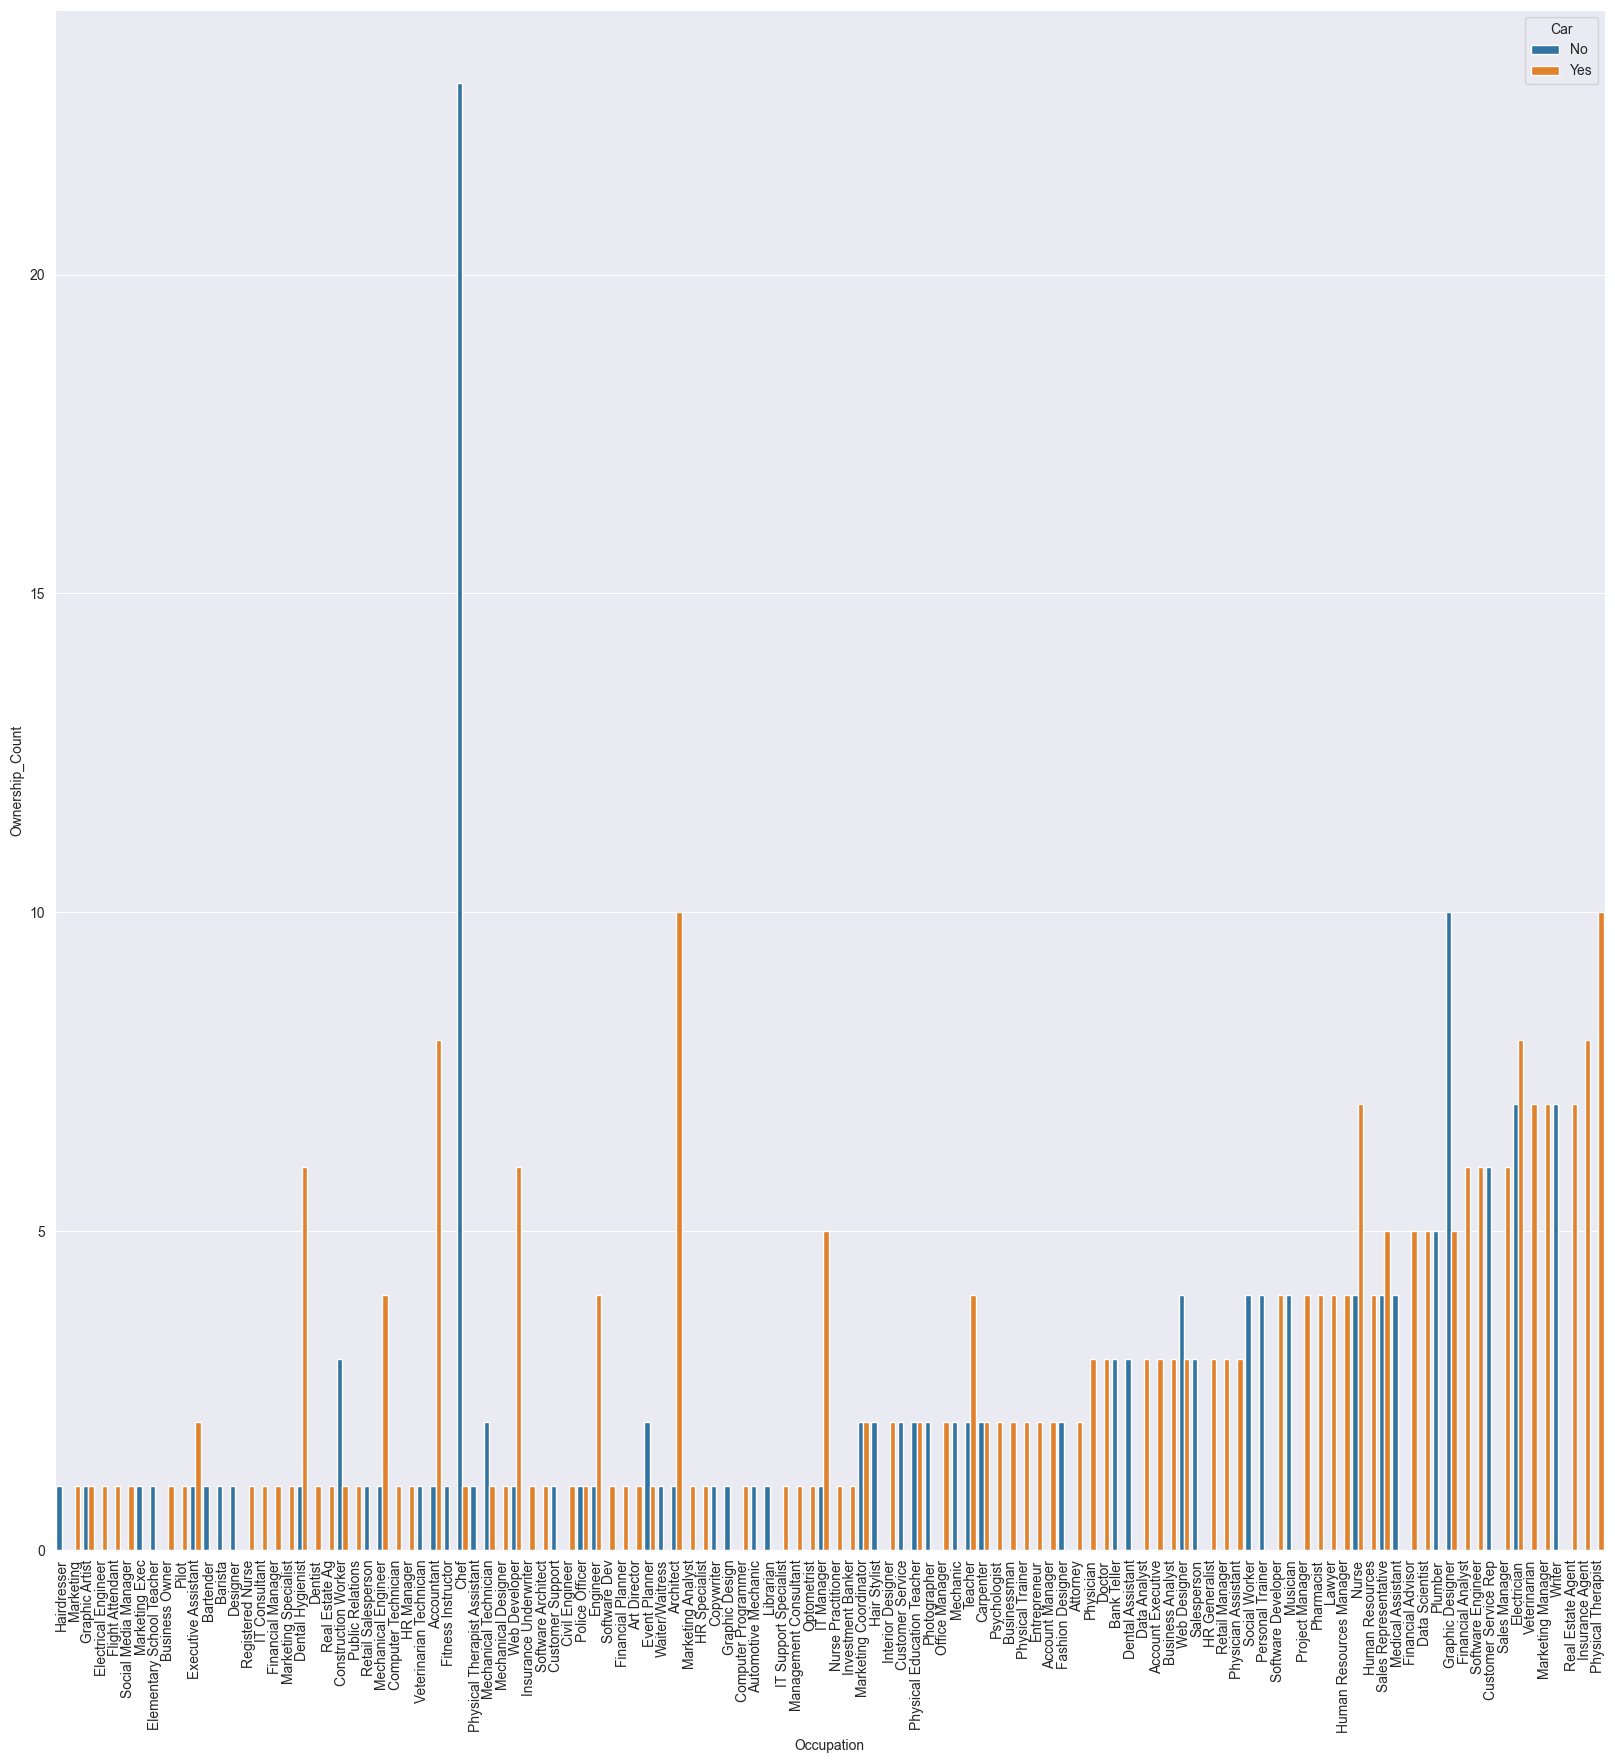

In [8]:
plt.figure(figsize=(20,20))
sb.barplot(data=filtered, x="Occupation", y="Ownership_Count", hue="Car")
plt.xticks(rotation=90)
plt.show()

In [9]:
explode = (0.1, 0, 0, 0.2, 0, 0, 0)
filtered = sql_to_df('''select Finance_status, count(Finance_Status) as Finance_Status_Counts from ownership
                        group by Finance_status
                        order by Finance_Status_Counts
                        ''')

filtered['Finance_Status_Counts'] = filtered['Finance_Status_Counts'].apply(lambda x: x / filtered['Finance_Status_Counts'].sum() * 100)
filtered

,Finance_status,Finance_Status_Counts
0,Poor,1.010101
1,Excellent,2.777778
2,Good,3.282828
3,Unknown,3.282828
4,Fair,3.535354
5,Unstable,18.181818
6,Stable,67.929293


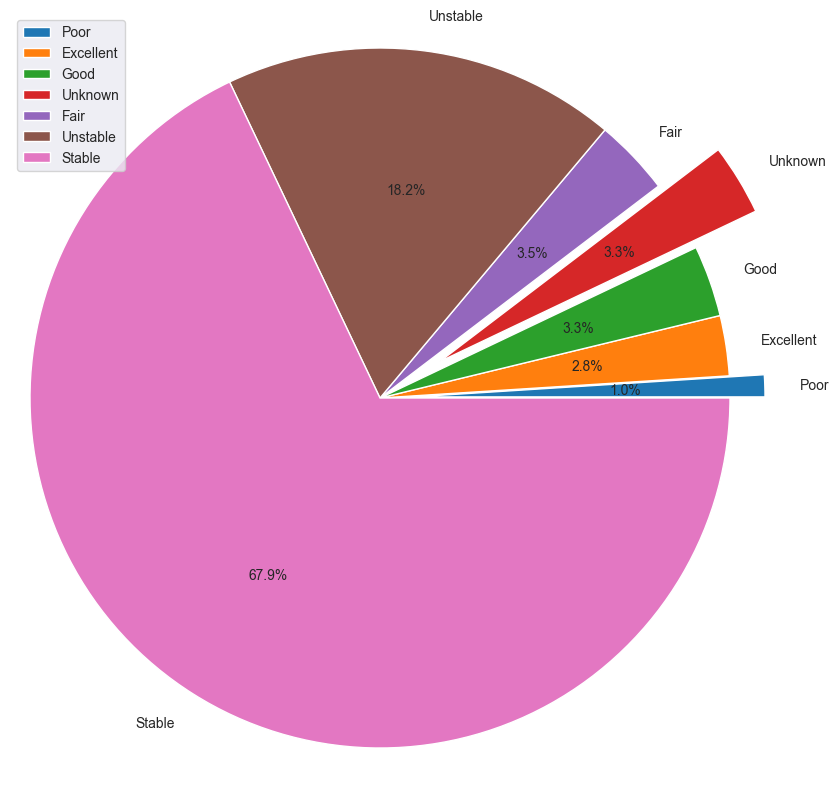

In [10]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Finance_Status_Counts'] ,explode=explode, labels=filtered['Finance_status'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [11]:
filtered = sql_to_df('''select Finance_status, Car, avg(Years_of_Employment) as Years_od_Employment_Average from ownership
                        group by Finance_status, Car
                        order by Years_od_Employment_Average''')
filtered

,Finance_status,Car,Years_od_Employment_Average
0,Unstable,No,1.611940
1,Poor,No,1.750000
2,Good,No,2.333333
3,Unstable,Yes,2.400000
4,Excellent,No,2.666667
5,Unknown,No,2.700000
6,Fair,No,3.000000
7,Stable,No,3.265306
8,Stable,Yes,5.377273
9,Unknown,Yes,6.000000


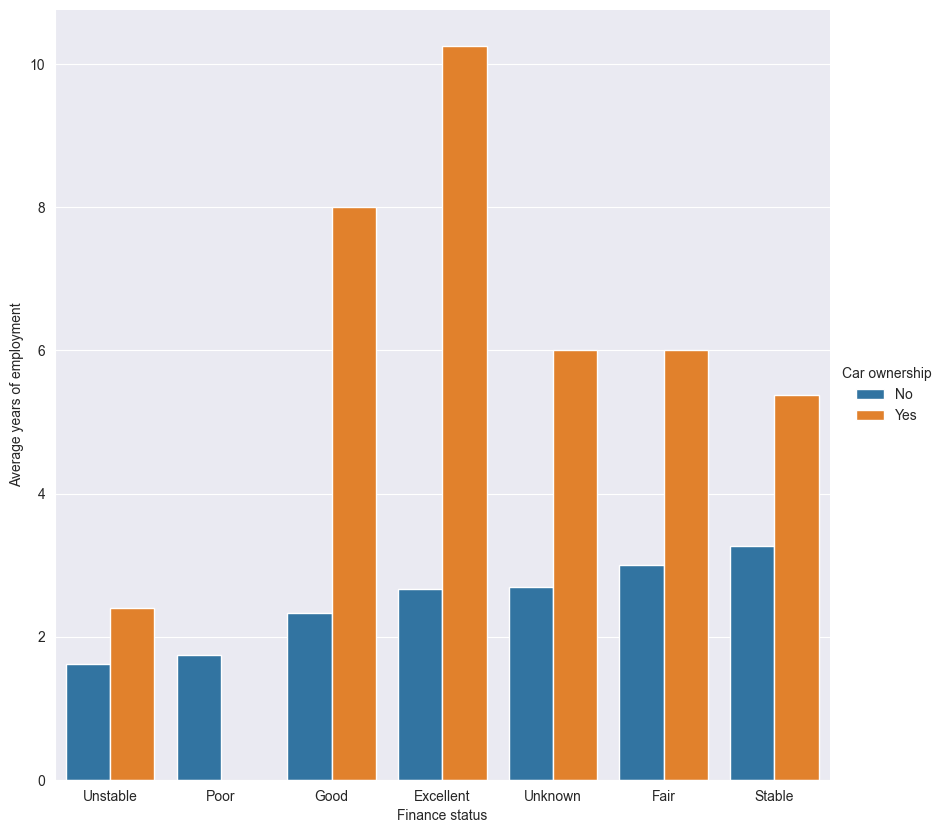

In [12]:
plt.figure(figsize=(10, 10))
ax = sb.barplot(x='Finance_status', y='Years_od_Employment_Average', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Average years of employment', xlabel='Finance status')
ax.legend(title='Car ownership')
sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

In [13]:
filtered = sql_to_df('''select Car,  count(Car) as Ownership_count, Number_of_Children from ownership
                        group by Number_of_Children, Car
                        having Number_of_Children > -1
                        order by Number_of_Children asc
                        ''')
filtered

,Car,Ownership_count,Number_of_Children
0,No,38,0
1,Yes,74,0
2,No,32,1
3,Yes,68,1
4,No,25,2
5,Yes,62,2
6,Yes,9,3
7,No,8,3
8,No,1,4


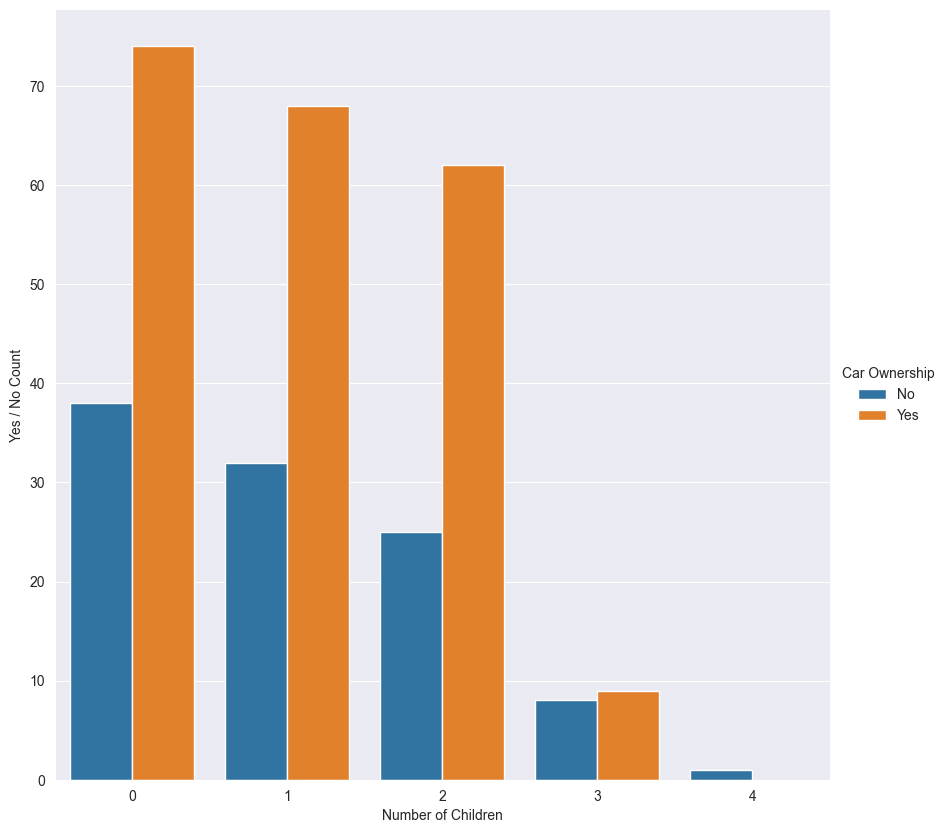

In [14]:
plt.figure(figsize=(10, 10))
ax = sb.barplot(x='Number_of_Children', y='Ownership_count', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Yes / No Count', xlabel='Number of Children')
ax.legend(title='Car Ownership')
sb.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

In [15]:
filtered = sql_to_df('''select Car, Annual_Income from ownership where Annual_Income < 66000''')
filtered

,Car,Annual_Income
0,Yes,52800.0
1,No,33000.0
2,Yes,46200.0
3,No,26400.0
4,Yes,7920.0
...,...,...
382,No,4620.0
383,Yes,6336.0
384,Yes,9240.0
385,No,4620.0


In [16]:
display(sql_to_df('''select count(Car) from ownership where Annual_Income > 66000 and Car == "No"'''))

,count(Car)
0,0


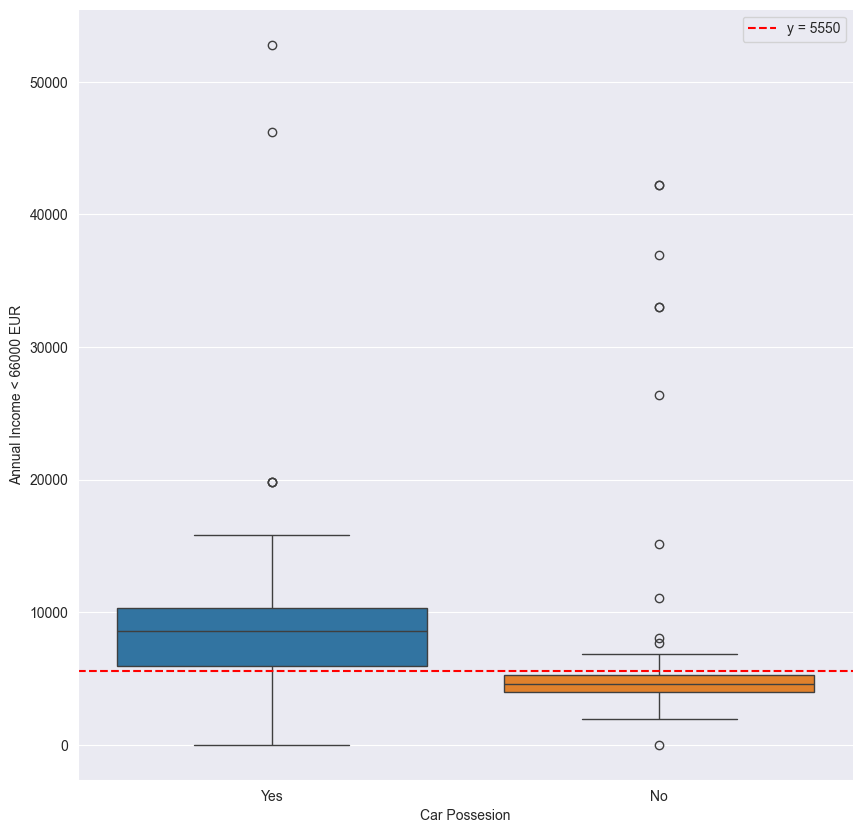

In [17]:
plt.figure(figsize=(10, 10))
ax = sb.boxplot(x='Car', y='Annual_Income', hue='Car', data=filtered)
ax.spines[['top', 'right']].set_visible(False)
ax.set(ylabel='Annual Income < 66000 EUR', xlabel='Car Possesion')
plt.axhline(y=5550, color='red', linestyle='--', label='y = 5550')
plt.legend()
plt.show()

In [18]:
sales_data.show()

+---+------------+----------+------+------------------+--------------------+----------+-------------+--------------------+------------+----------+-----+----------+----------+-------+-------------+-----+----+
|_c0|      Car_id|      Date|Gender|     Annual_Income|         Dealer_Name|   Company|        Model|              Engine|Transmission|     Color|Price|Dealer_No |Body_Style|  Phone|Dealer_Region|Month|Year|
+---+------------+----------+------+------------------+--------------------+----------+-------------+--------------------+------------+----------+-----+----------+----------+-------+-------------+-----+----+
|  0|C_CND_000001|2022-01-02|  Male|             148.5|Buddy Storbeck's ...|      Ford|   Expedition|DoubleÂ Overhead ...|        Auto|     Black|26000|06457-3834|       SUV|8264678|   Middletown|    1|2022|
|  1|C_CND_000002|2022-01-02|  Male|16279.999999999998|    C & M Motors Inc|     Dodge|      Durango|DoubleÂ Overhead ...|        Auto|     Black|19000|60504-7114|     

In [19]:
filtered = sql_to_df('''select Gender, count(Gender) as Gender_Count from sales
                        group by Gender''')
filtered['Gender_Count'] = filtered['Gender_Count'].apply(lambda x: x / filtered['Gender_Count'].sum() * 100)
filtered

,Gender,Gender_Count
0,Female,21.367021
1,Male,78.632979


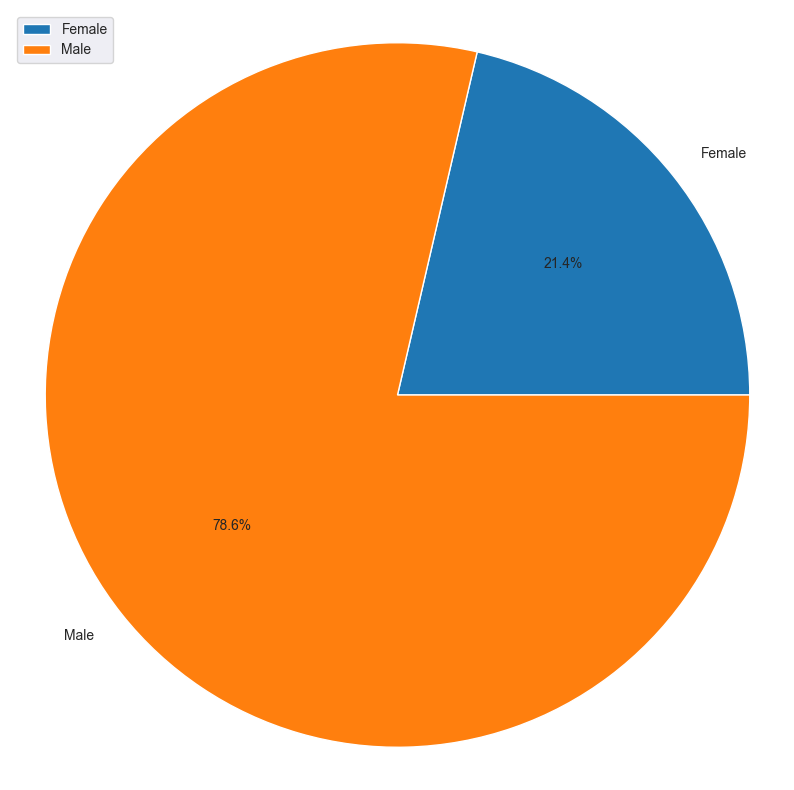

In [20]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Gender_Count'], labels=filtered['Gender'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.show()

In [21]:
filtered = sql_to_df('''select Gender, Annual_Income, Price from sales''')
filtered

,Gender,Annual_Income,Price
0,Male,148.5,26000
1,Male,16280.0,19000
2,Male,11385.0,31500
3,Male,148.5,14000
4,Male,16115.0,24500
...,...,...,...
23901,Male,148.5,12000
23902,Female,9900.0,16000
23903,Male,7755.0,21000
23904,Male,148.5,31000


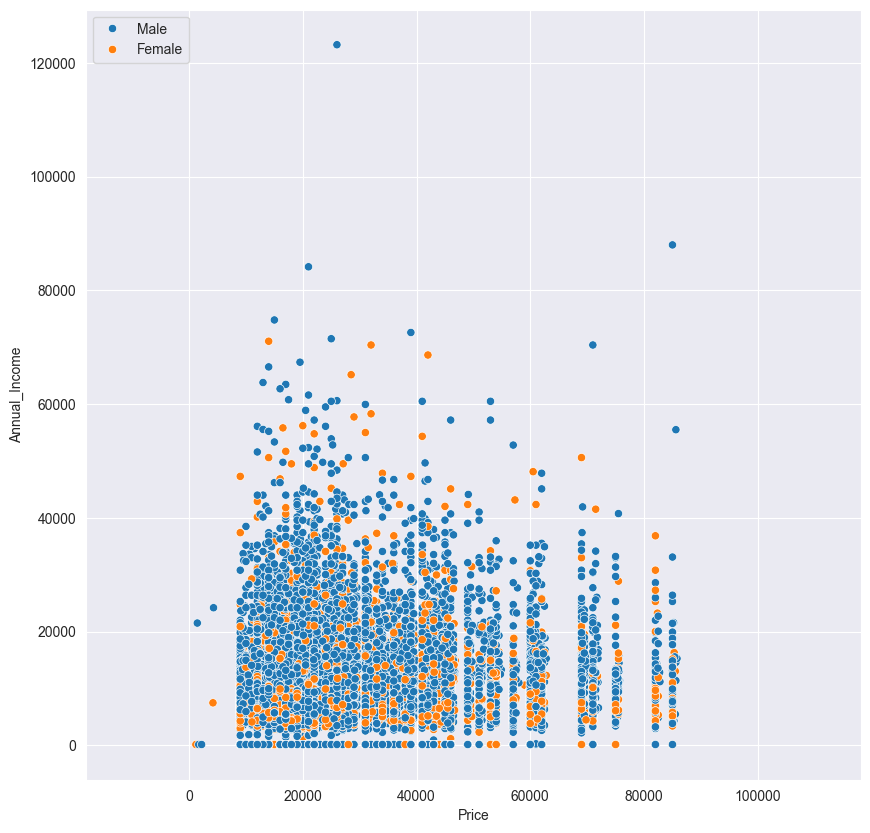

In [22]:
plt.figure(figsize=(10,10))
sb.scatterplot(data=filtered, x='Price', y='Annual_Income', hue='Gender')
plt.axis('equal')
plt.xlim(0, 100000)
plt.legend(loc='upper left')

In [23]:
filtered = sql_to_df('''select Gender, Company, count(Company) as Company_Gender_Count from sales 
                        group by Gender, Company
                        having  Gender == "Male"
                        order by Company_Gender_Count''')
filtered

,Gender,Company,Company_Gender_Count
0,Male,Jaguar,149
1,Male,Infiniti,160
2,Male,Saab,164
3,Male,Hyundai,212
4,Male,Porsche,277
5,Male,Jeep,296
6,Male,Subaru,335
7,Male,Buick,352
8,Male,Audi,382
9,Male,Lincoln,386


In [24]:
filtered['Company_Gender_Count'] = filtered['Company_Gender_Count'].apply(lambda x: np.round(x / filtered['Company_Gender_Count'].sum() * 100, 2))

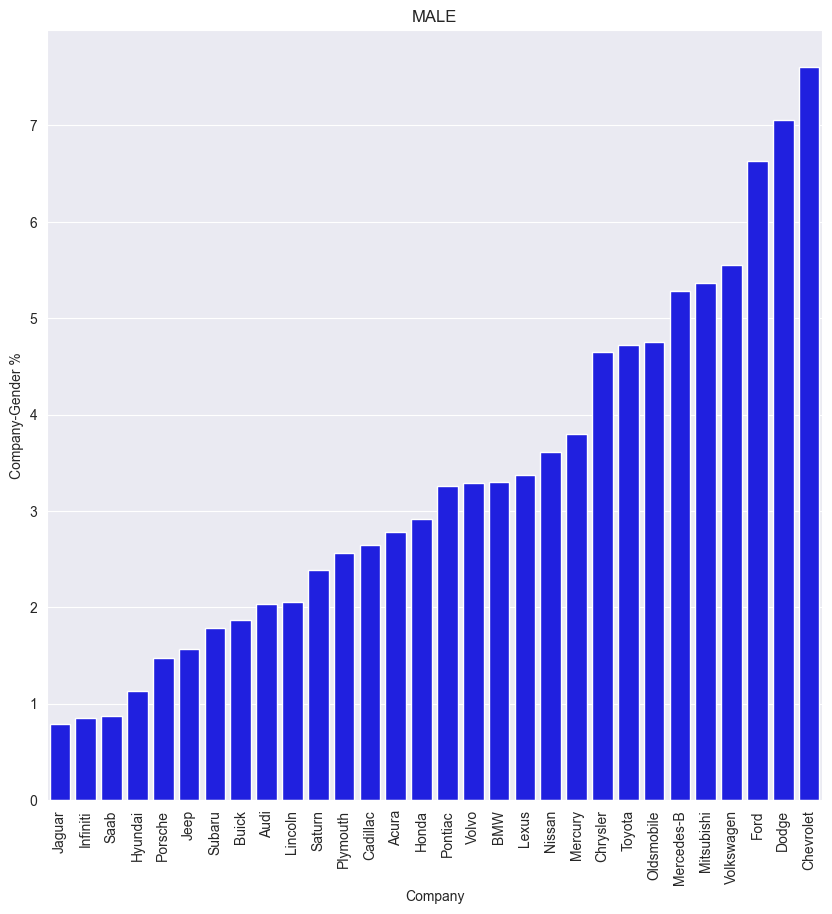

In [25]:
plt.figure(figsize=(10,10))
ax = sb.barplot(data=filtered, x='Company', y='Company_Gender_Count', color='blue')
plt.xticks(rotation=90)
ax.set(ylabel='Company-Gender %')
plt.title('MALE')
plt.show()

In [26]:
filtered = sql_to_df('''select Gender, Company, count(Company) as Company_Gender_Count from sales 
                        group by Gender, Company
                        having  Gender == "Female"
                        order by Company_Gender_Count desc''')
filtered

,Gender,Company,Company_Gender_Count
0,Female,Chevrolet,388
1,Female,Ford,367
2,Female,Dodge,344
3,Female,Mercedes-B,292
4,Female,Volkswagen,289
5,Female,Mitsubishi,269
6,Female,Chrysler,246
7,Female,Toyota,222
8,Female,Oldsmobile,218
9,Female,Nissan,208


In [27]:
filtered['Company_Gender_Count'] = filtered['Company_Gender_Count'].apply(lambda x: np.round(x / filtered['Company_Gender_Count'].sum() * 100, 2))

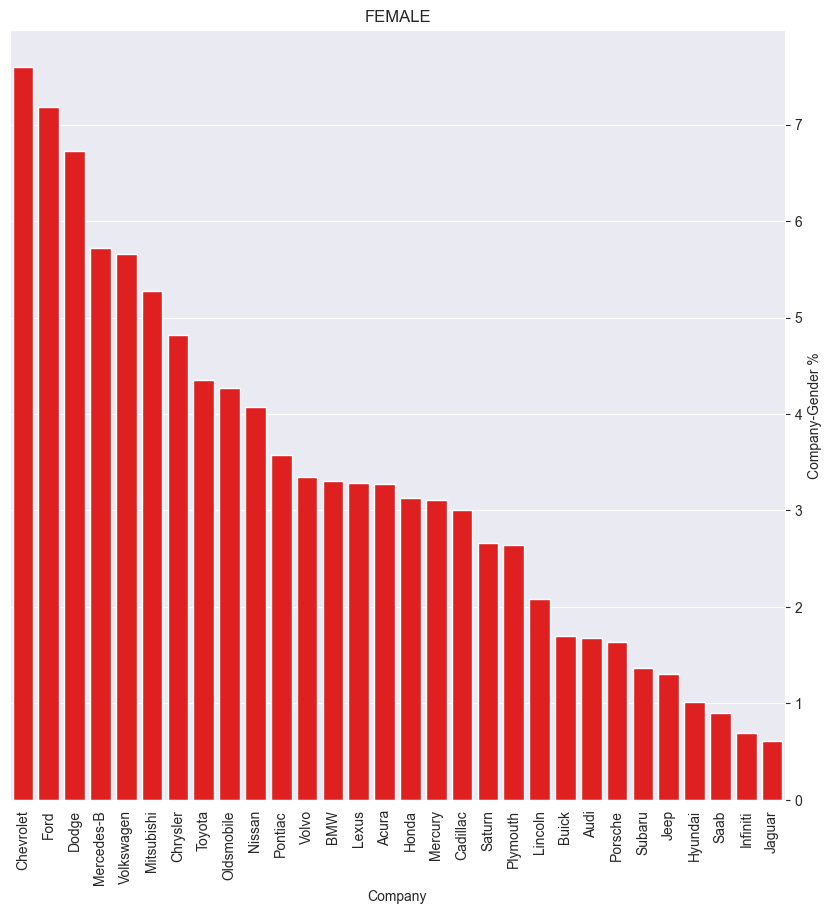

In [28]:
plt.figure(figsize=(10,10))
ax = sb.barplot(data=filtered, x='Company', y='Company_Gender_Count', color='red')
plt.xticks(rotation=90)
ax.set(ylabel='Company-Gender %')
plt.title('FEMALE')
ax.yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.show()

In [29]:
filtered = sql_to_df('''select Gender, Transmission, count(Transmission) as Transmission_Counts from sales
                        group by Gender, Transmission
                        having Gender == "Male"''')
filtered

,Gender,Transmission,Transmission_Counts
0,Male,Manual,8926
1,Male,Auto,9872


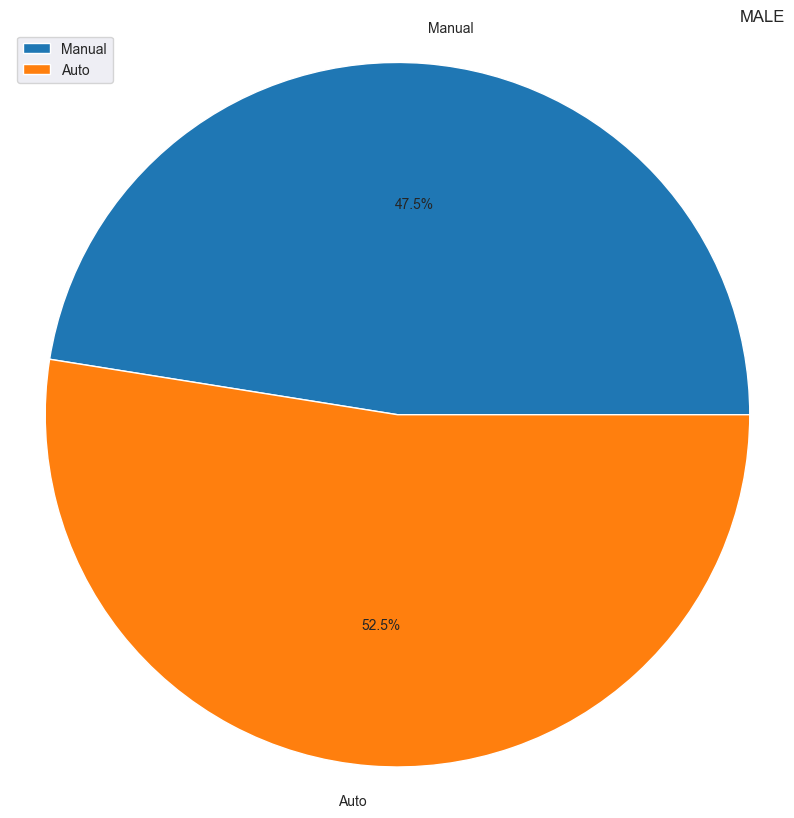

In [30]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Transmission_Counts'], labels=filtered['Transmission'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.title("MALE", loc='right')
plt.show()

In [31]:
filtered = sql_to_df('''select Gender, Transmission, count(Transmission) as Transmission_Counts from sales
                        group by Gender, Transmission
                        having Gender == "Female"''')
filtered

,Gender,Transmission,Transmission_Counts
0,Female,Auto,2699
1,Female,Manual,2409


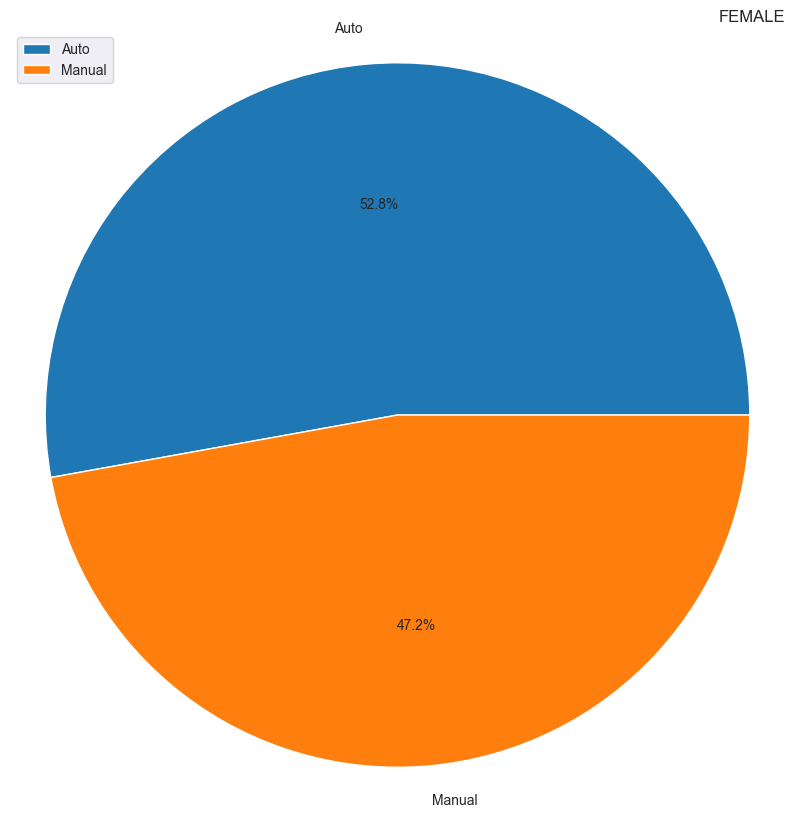

In [32]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Transmission_Counts'], labels=filtered['Transmission'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.title("FEMALE", loc='right')
plt.show()

In [33]:
filtered = sql_to_df('''select Year, Month, sum(Price) as Month_Profit from sales
                        group by Year, Month
                        order by Year asc, Month asc''')

filtered

,Year,Month,Month_Profit
0,2022,1,8931920
1,2022,2,8795365
2,2022,3,19502059
3,2022,4,22748867
4,2022,5,20608086
5,2022,6,19604211
6,2022,7,19935002
7,2022,8,23631362
8,2022,9,42218216
9,2022,10,23991509


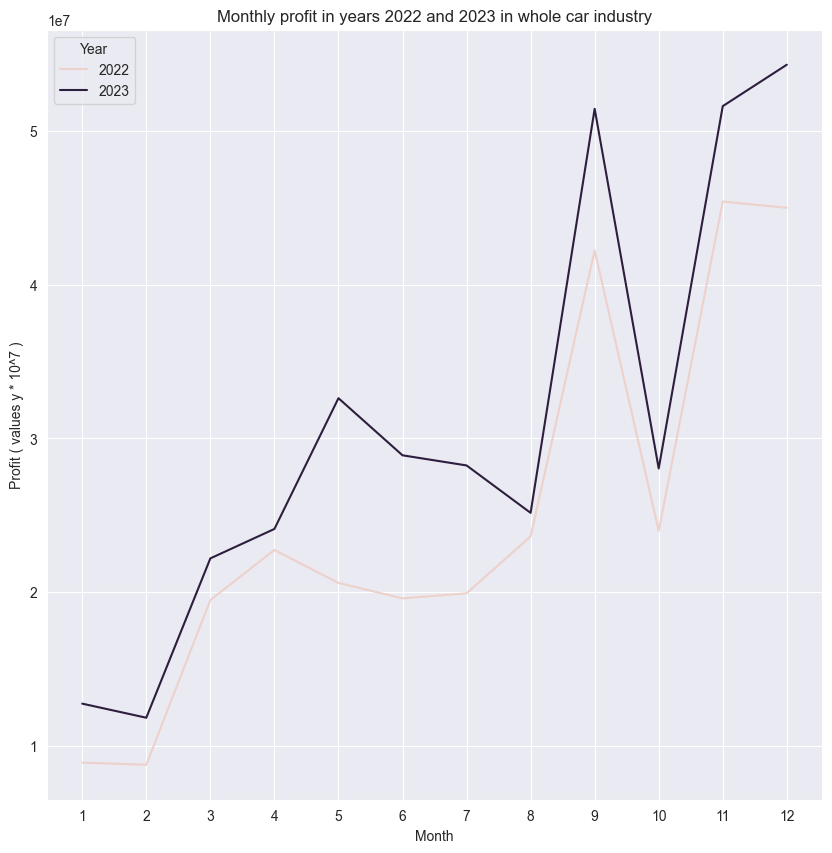

In [34]:
plt.figure(figsize=(10,10))
sb.lineplot(data=filtered, x='Month', y='Month_Profit', hue='Year')
plt.xticks(np.arange(1, 13, 1))
plt.title("Monthly profit in years 2022 and 2023 in whole car industry")
plt.ylabel("Profit ( values y * 10^7 )")
plt.show()

In [35]:
filtered = sql_to_df('''select Dealer_Name, sum(Price) as Total_Profit from sales
                        group by Dealer_Name
                        order by Total_Profit asc ''')
filtered

,Dealer_Name,Total_Profit
0,Buddy Storbeck's Diesel Service Inc,17065223
1,Pitre Buick-Pontiac-Gmc of Scottsdale,17209868
2,Chrysler Plymouth,17222204
3,McKinney Dodge Chrysler Jeep,17413297
4,Clay Johnson Auto Sales,17440649
5,Diehl Motor CO Inc,17468212
6,Motor Vehicle Branch Office,17500919
7,Hatfield Volkswagen,17519985
8,New Castle Ford Lincoln Mercury,17528426
9,C & M Motors Inc,17569847


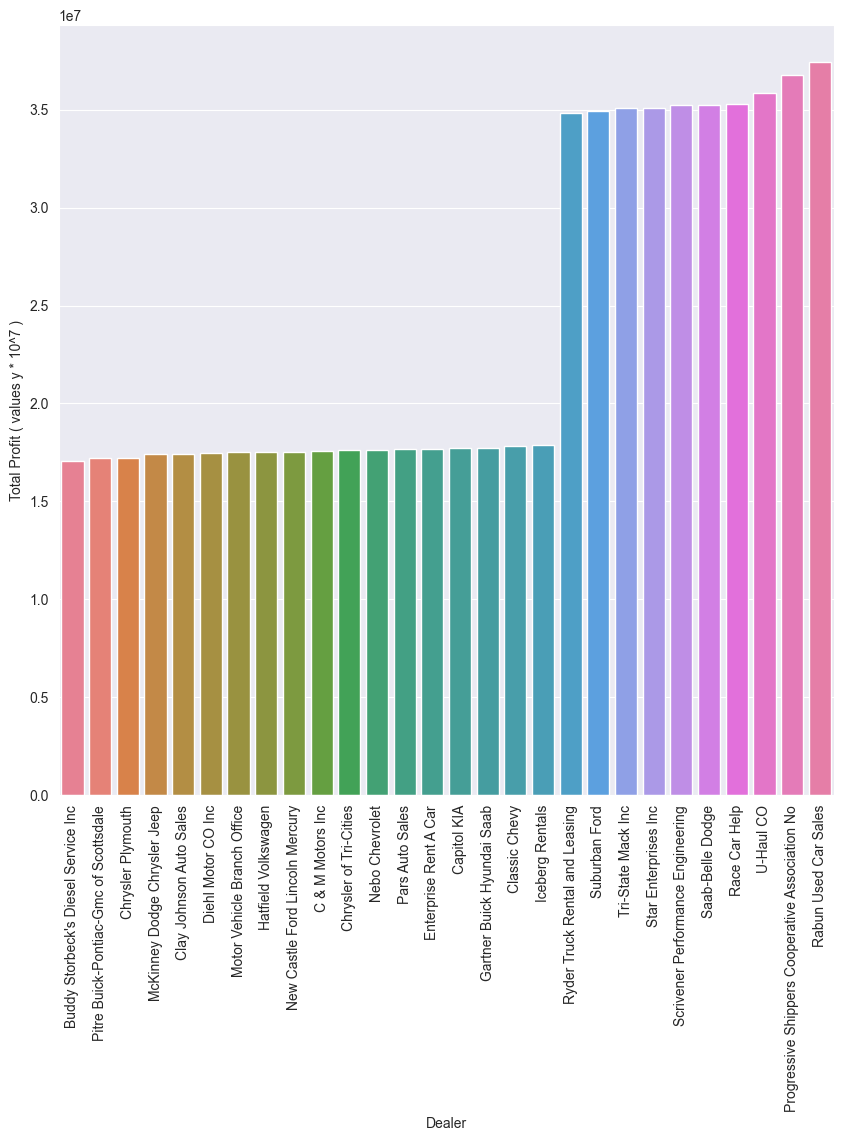

In [36]:
plt.figure(figsize=(10,10))
ax = sb.barplot(data=filtered, x='Dealer_Name', y='Total_Profit', hue='Dealer_Name')
plt.xticks(rotation=90)
ax.set(ylabel='Total Profit ( values y * 10^7 )', xlabel='Dealer')
plt.show()

In [37]:
# Gender and Body_Style
filtered = sql_to_df('''select Gender, Body_Style, count(Body_Style) as Body_Style_Counts from sales
                        group by Body_Style, Gender 
                        having Gender == "Male"''')
filtered

,Gender,Body_Style,Body_Style_Counts
0,Male,Hatchback,4830
1,Male,Hardtop,2324
2,Male,Sedan,3543
3,Male,SUV,5039
4,Male,Passenger,3062


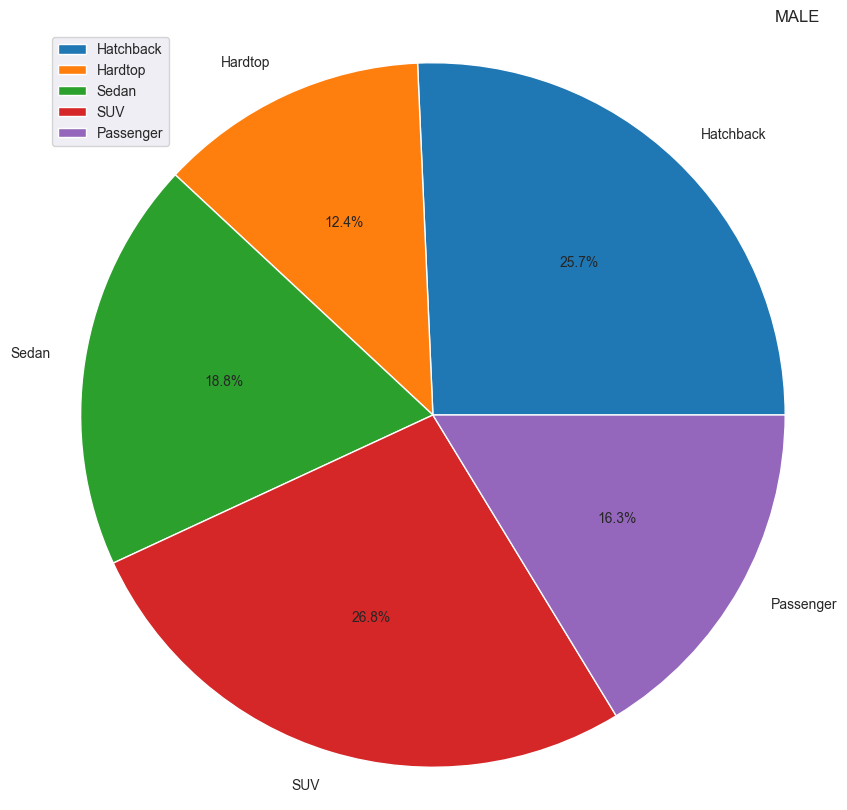

In [38]:
plt.figure(figsize=(10,10))
plt.pie(x=filtered['Body_Style_Counts'], labels=filtered['Body_Style'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.title("MALE", loc='right')
plt.show()

In [39]:
filtered = sql_to_df('''select Gender, Body_Style, count(Body_Style) as Body_Style_Counts from sales
                        group by Body_Style, Gender 
                        having Gender == "Female"''')
filtered

,Gender,Body_Style,Body_Style_Counts
0,Female,Sedan,945
1,Female,Hatchback,1298
2,Female,Hardtop,647
3,Female,Passenger,883
4,Female,SUV,1335


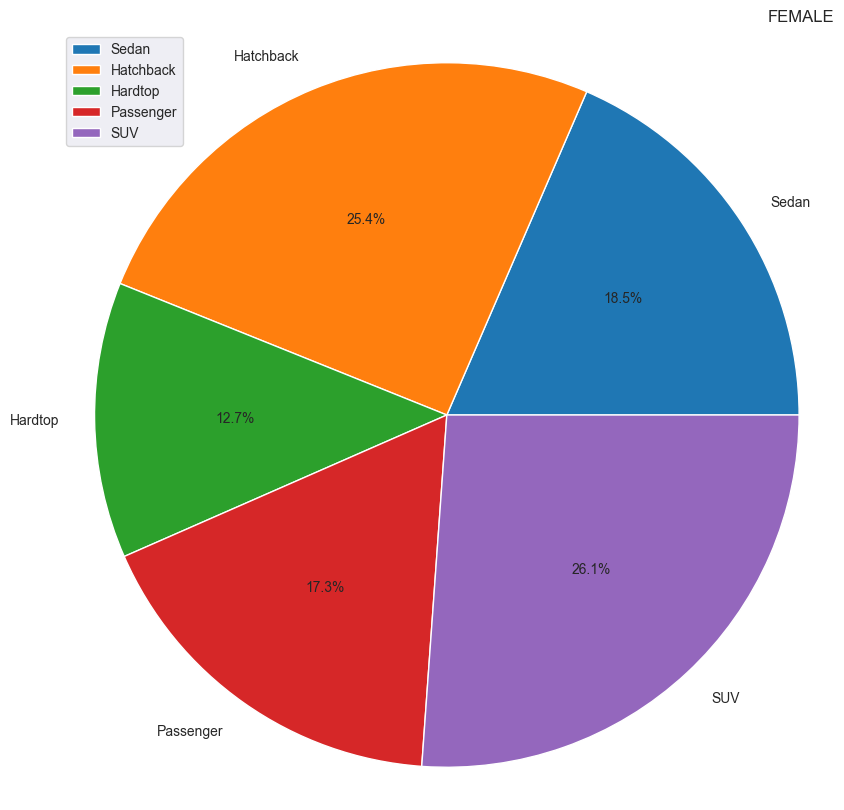

In [40]:

plt.figure(figsize=(10, 10))
plt.pie(x=filtered['Body_Style_Counts'], labels=filtered['Body_Style'], autopct='%1.1f%%')
plt.axis('equal')
plt.legend(loc='upper left')
plt.title("FEMALE", loc='right')
plt.show()

In [41]:
filtered = sql_to_df('''select * from ownership''')
filtered['Car'] = filtered['Car'].replace({"No":0})
filtered['Car'] = filtered['Car'].replace({"Yes":1})
filtered

,_c0,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
0,0,Teacher,52800.0,750,10,Good,1,2
1,1,Engineer,79200.0,800,8,Good,1,1
2,2,Nurse,33000.0,650,5,Fair,0,0
3,3,Doctor,105600.0,900,12,Excellent,1,3
4,4,Businessman,132000.0,700,15,Good,1,2
...,...,...,...,...,...,...,...,...
391,493,Customer Support,4620.0,640,3,Stable,0,1
392,494,Dental Hygienist,6336.0,670,4,Stable,1,2
393,495,Project Manager,9240.0,730,5,Stable,1,0
394,498,Medical Assistant,4620.0,640,3,Stable,0,1


<Figure size 1000x1000 with 0 Axes>

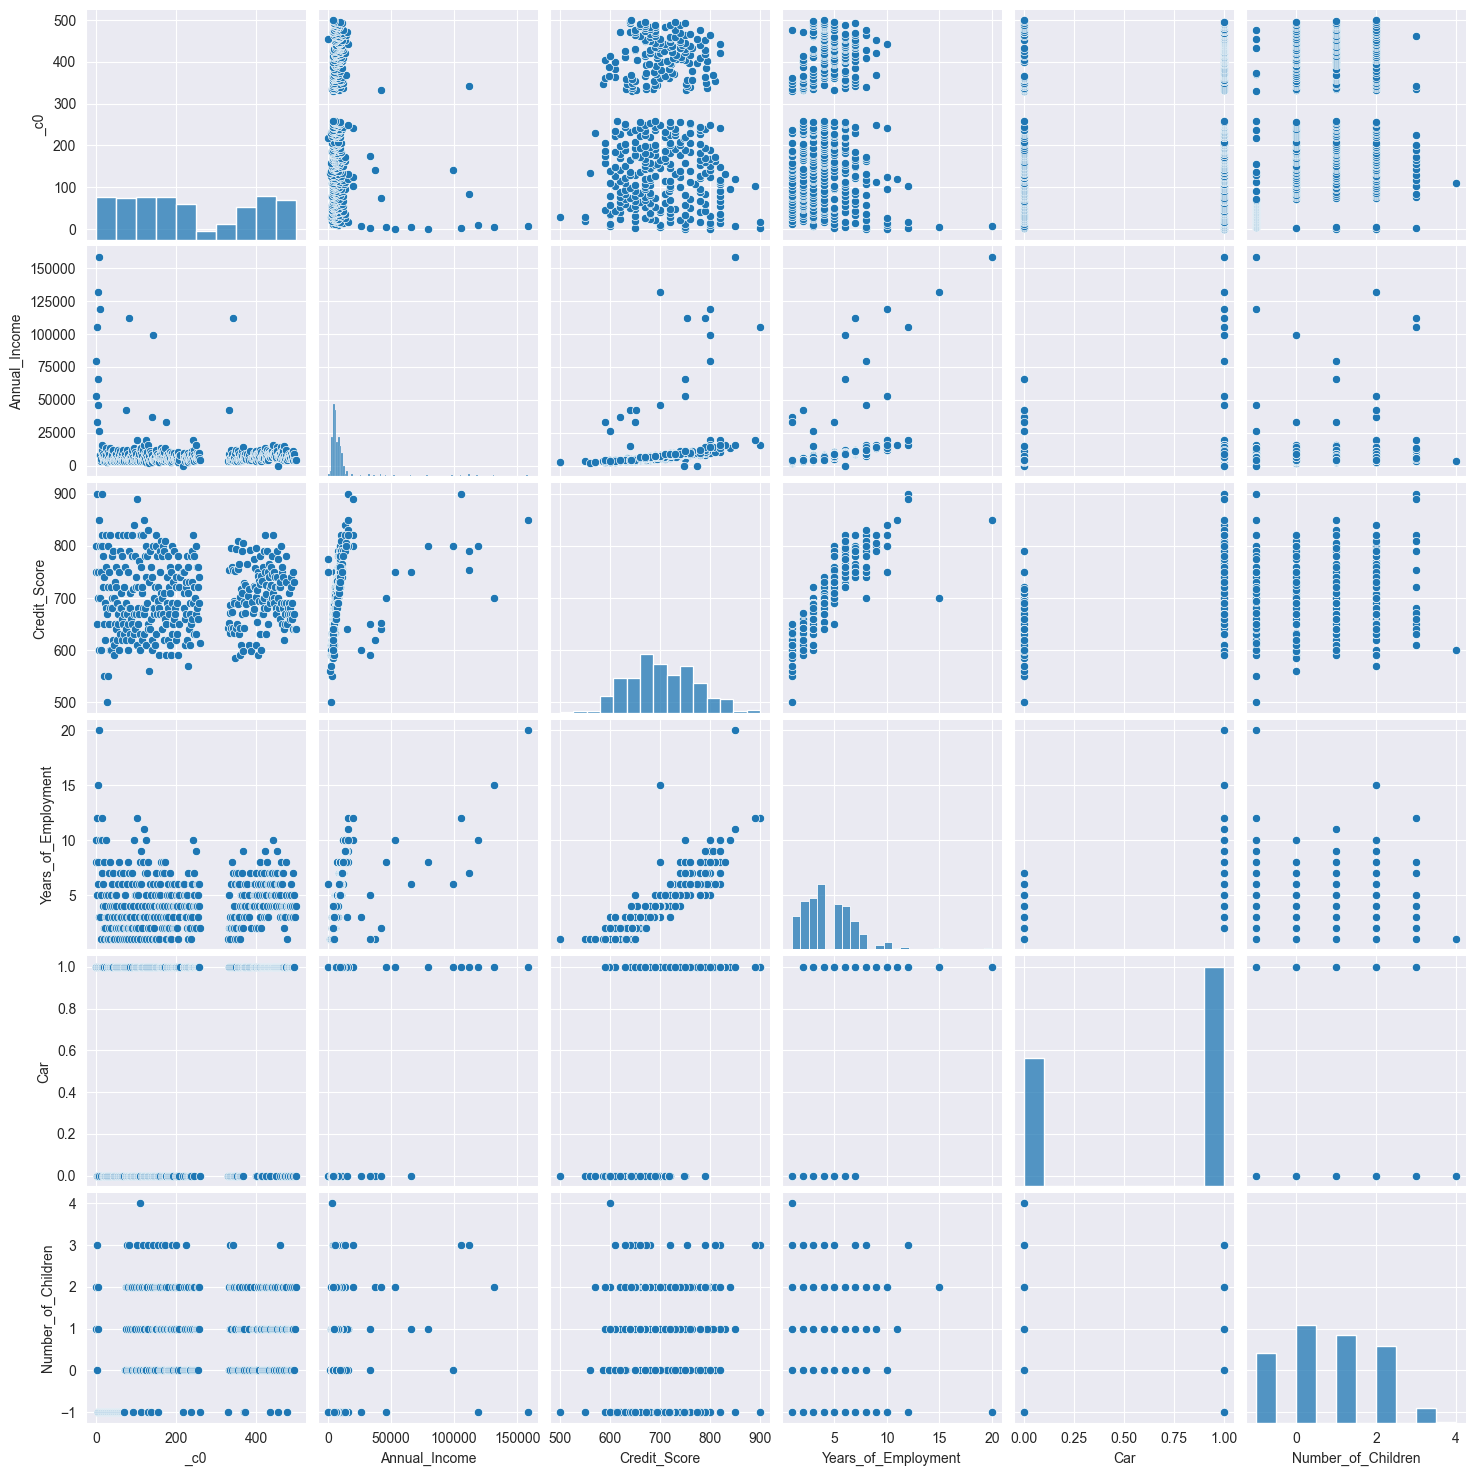

In [42]:
# add two heatmaps and two pairplots for the end
plt.figure(figsize=(10, 10))
sb.pairplot(data=filtered)
plt.show()

In [43]:
filtered = filtered[['Annual_Income', 'Years_of_Employment', 'Car', 'Number_of_Children']]
filtered

,Annual_Income,Years_of_Employment,Car,Number_of_Children
0,52800.0,10,1,2
1,79200.0,8,1,1
2,33000.0,5,0,0
3,105600.0,12,1,3
4,132000.0,15,1,2
...,...,...,...,...
391,4620.0,3,0,1
392,6336.0,4,1,2
393,9240.0,5,1,0
394,4620.0,3,0,1


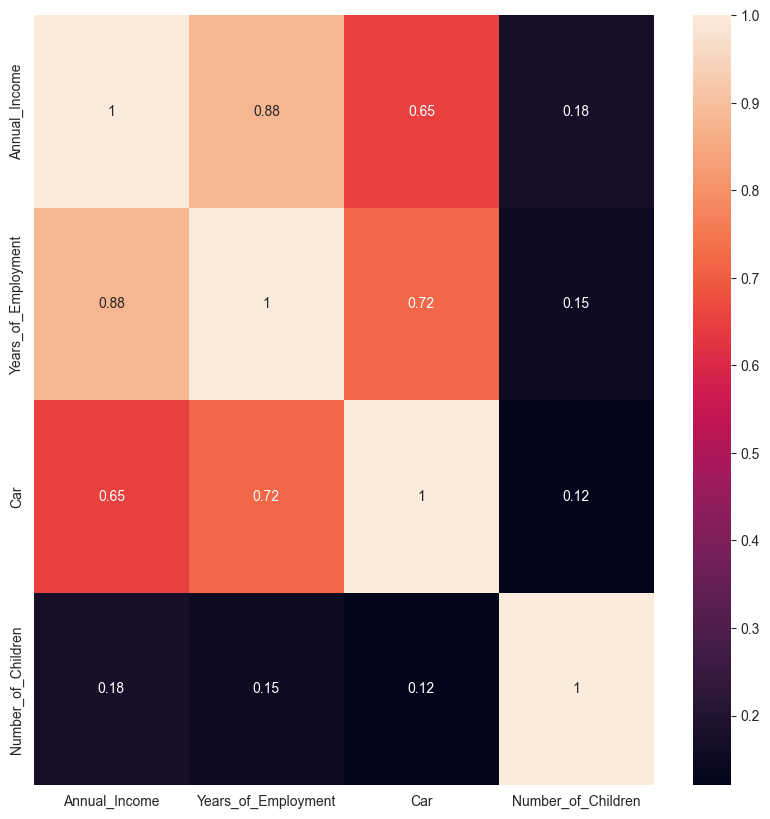

In [44]:
plt.figure(figsize=(10, 10))
sb.heatmap(data=filtered.corr(method='spearman'), annot=True)
plt.show()

In [45]:
filtered = sql_to_df('''select * from sales''')
filtered = filtered.drop(columns=['_c0', 'Car_id', 'Date', 'Engine', 'Dealer_No ', 'Phone'])
filtered

,Gender,Annual_Income,Dealer_Name,Company,Model,Transmission,Color,Price,Body_Style,Dealer_Region,Month,Year
0,Male,148.5,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Auto,Black,26000,SUV,Middletown,1,2022
1,Male,16280.0,C & M Motors Inc,Dodge,Durango,Auto,Black,19000,SUV,Aurora,1,2022
2,Male,11385.0,Capitol KIA,Cadillac,Eldorado,Manual,Red,31500,Passenger,Greenville,1,2022
3,Male,148.5,Chrysler of Tri-Cities,Toyota,Celica,Manual,Pale White,14000,SUV,Pasco,1,2022
4,Male,16115.0,Chrysler Plymouth,Acura,TL,Auto,Red,24500,Hatchback,Janesville,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
23901,Male,148.5,C & M Motors Inc,Plymouth,Voyager,Manual,Red,12000,Passenger,Pasco,12,2023
23902,Female,9900.0,Ryder Truck Rental and Leasing,Chevrolet,Prizm,Auto,Black,16000,Hardtop,Middletown,12,2023
23903,Male,7755.0,Chrysler of Tri-Cities,BMW,328i,Manual,Red,21000,Sedan,Scottsdale,12,2023
23904,Male,148.5,Chrysler Plymouth,Chevrolet,Metro,Auto,Black,31000,Passenger,Austin,12,2023


<Figure size 1000x1000 with 0 Axes>

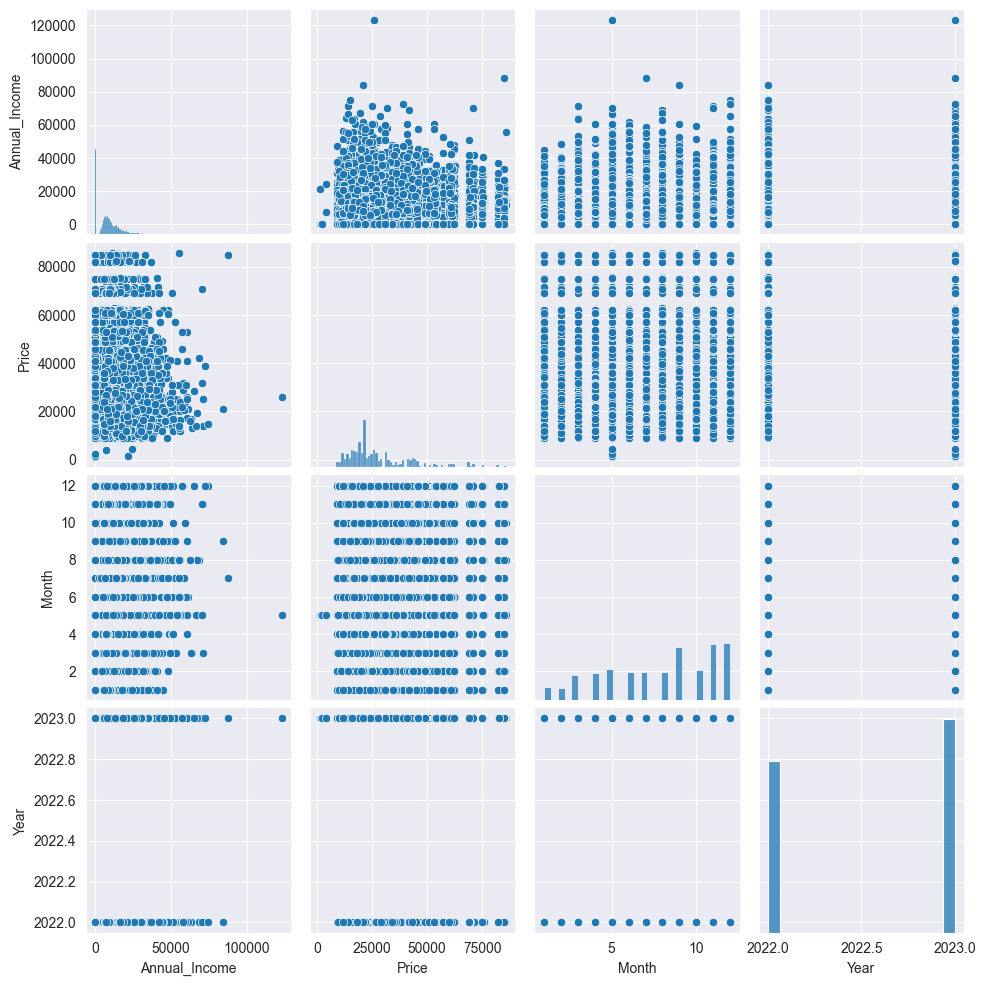

In [46]:
plt.figure(figsize=(10, 10))
sb.pairplot(data=filtered)
plt.show()

In [47]:
filtered['Gender'] = filtered['Gender'].replace({"Male":0})
filtered['Gender'] = filtered['Gender'].replace({"Female":1})
filtered

,Gender,Annual_Income,Dealer_Name,Company,Model,Transmission,Color,Price,Body_Style,Dealer_Region,Month,Year
0,0,148.5,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Auto,Black,26000,SUV,Middletown,1,2022
1,0,16280.0,C & M Motors Inc,Dodge,Durango,Auto,Black,19000,SUV,Aurora,1,2022
2,0,11385.0,Capitol KIA,Cadillac,Eldorado,Manual,Red,31500,Passenger,Greenville,1,2022
3,0,148.5,Chrysler of Tri-Cities,Toyota,Celica,Manual,Pale White,14000,SUV,Pasco,1,2022
4,0,16115.0,Chrysler Plymouth,Acura,TL,Auto,Red,24500,Hatchback,Janesville,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
23901,0,148.5,C & M Motors Inc,Plymouth,Voyager,Manual,Red,12000,Passenger,Pasco,12,2023
23902,1,9900.0,Ryder Truck Rental and Leasing,Chevrolet,Prizm,Auto,Black,16000,Hardtop,Middletown,12,2023
23903,0,7755.0,Chrysler of Tri-Cities,BMW,328i,Manual,Red,21000,Sedan,Scottsdale,12,2023
23904,0,148.5,Chrysler Plymouth,Chevrolet,Metro,Auto,Black,31000,Passenger,Austin,12,2023


In [48]:
filtered = filtered[['Annual_Income', 'Price', 'Month', 'Year', 'Gender']]

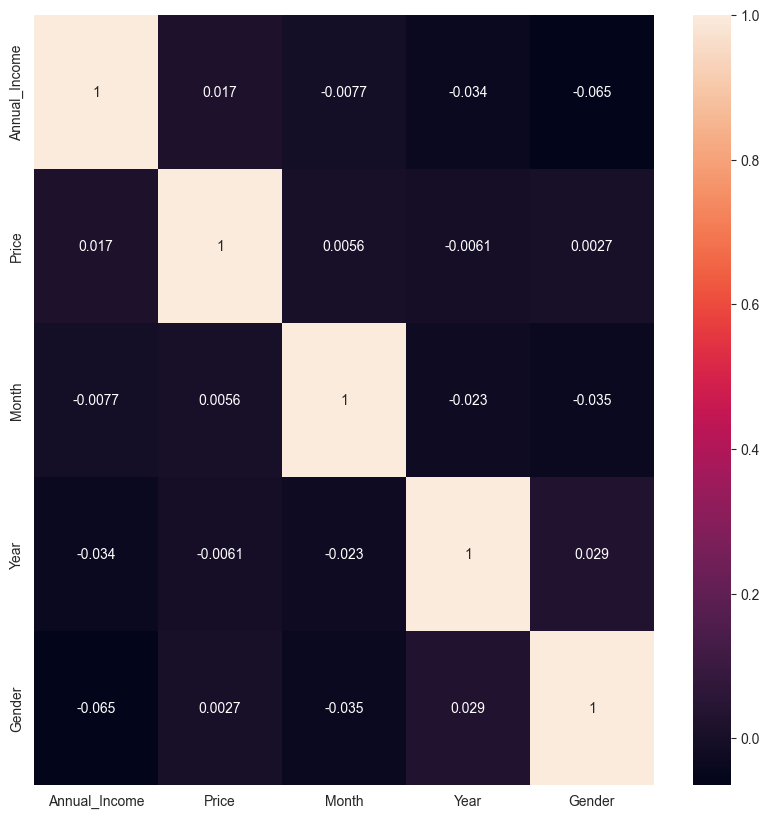

In [49]:
plt.figure(figsize=(10, 10))
sb.heatmap(data=filtered.corr(method='spearman'), annot=True)
plt.show()

In [50]:
ownership_pandas_dataset = sql_to_df('''select * from ownership''')
sales_pandas_dataset = sql_to_df('''select * from sales''')

In [51]:
ownership_pandas_dataset

,_c0,Occupation,Annual_Income,Credit_Score,Years_of_Employment,Finance_Status,Car,Number_of_Children
0,0,Teacher,52800.0,750,10,Good,Yes,2
1,1,Engineer,79200.0,800,8,Good,Yes,1
2,2,Nurse,33000.0,650,5,Fair,No,0
3,3,Doctor,105600.0,900,12,Excellent,Yes,3
4,4,Businessman,132000.0,700,15,Good,Yes,2
...,...,...,...,...,...,...,...,...
391,493,Customer Support,4620.0,640,3,Stable,No,1
392,494,Dental Hygienist,6336.0,670,4,Stable,Yes,2
393,495,Project Manager,9240.0,730,5,Stable,Yes,0
394,498,Medical Assistant,4620.0,640,3,Stable,No,1


In [52]:
sales_pandas_dataset

,_c0,Car_id,Date,Gender,Annual_Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price,Dealer_No,Body_Style,Phone,Dealer_Region,Month,Year
0,0,C_CND_000001,2022-01-02,Male,148.5,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown,1,2022
1,1,C_CND_000002,2022-01-02,Male,16280.0,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora,1,2022
2,2,C_CND_000003,2022-01-02,Male,11385.0,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville,1,2022
3,3,C_CND_000004,2022-01-02,Male,148.5,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco,1,2022
4,4,C_CND_000005,2022-01-02,Male,16115.0,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23901,23901,C_CND_023902,2023-12-31,Male,148.5,C & M Motors Inc,Plymouth,Voyager,Overhead Camshaft,Manual,Red,12000,60504-7114,Passenger,8583598,Pasco,12,2023
23902,23902,C_CND_023903,2023-12-31,Female,9900.0,Ryder Truck Rental and Leasing,Chevrolet,Prizm,DoubleÂ Overhead Camshaft,Auto,Black,16000,06457-3834,Hardtop,7914229,Middletown,12,2023
23903,23903,C_CND_023904,2023-12-31,Male,7755.0,Chrysler of Tri-Cities,BMW,328i,Overhead Camshaft,Manual,Red,21000,99301-3882,Sedan,7659127,Scottsdale,12,2023
23904,23904,C_CND_023905,2023-12-31,Male,148.5,Chrysler Plymouth,Chevrolet,Metro,DoubleÂ Overhead Camshaft,Auto,Black,31000,53546-9427,Passenger,6030764,Austin,12,2023


In [53]:
city_to_state = {
    "Middletown": "Connecticut",
    "Aurora": "Colorado",
    "Greenville": "South Carolina",
    "Pasco": "Washington",
    "Janesville": "Wisconsin",
    "Scottsdale": "Arizona",
    "Austin": "Texas"
}
sales_pandas_dataset['Dealer_Region'] = sales_pandas_dataset['Dealer_Region'].replace(city_to_state)
sales_pandas_dataset['Dealer_Region']

0           Connecticut
1              Colorado
2        South Carolina
3            Washington
4             Wisconsin
              ...      
23901        Washington
23902       Connecticut
23903           Arizona
23904             Texas
23905       Connecticut
Name: Dealer_Region, Length: 23906, dtype: object

In [54]:
sales_by_city = sales_pandas_dataset.groupby('Dealer_Region')['Price'].sum().reset_index()

map1 = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

choropleth = folium.Choropleth(
    geo_data= '../../data/clean_data/map_data/us-states.json',
    data=sales_by_city,
    columns=['Dealer_Region', 'Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Automobile Sales in specific states'
).add_to(map1)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], labels=True)
)

map1

In [55]:
sales_pandas_dataset.to_csv(path_or_buf="../../data/final_data/final_sales_data.csv")
ownership_pandas_dataset.to_csv(path_or_buf="../../data/final_data/final_ownership_data.csv")

In [56]:
spark.stop()